In [1]:
import sys
import os

PYOM_DIR = "./datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)
from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d
from sklearn.pipeline import Pipeline
    
import torch
from models import MotionTransformer
from utils.get_opt import get_opt
import numpy as np
from os.path import join as pjoin
from trainers import DDPMTrainer
import matplotlib.pyplot as plt

In [2]:
# ✅ CORRECT PIPELINE DEFINITION
pipeline = Pipeline([
    ('param', MocapParameterizer('position')),
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('absolute_translation_deltas')),
    ('const', ConstantsRemover()),
    ('np', Numpyfier()),
    ('down', DownSampler(2)),
    ('stdscale', ListStandardScaler())
])

print("   Pipeline created with steps:")
for name, step in pipeline.steps:
    print(f"     - {name}: {step.__class__.__name__}")

bvh_sample_path = "./datasets/2_scott_0_55_55.bvh"
print(f"\n   Fitting on: {os.path.basename(bvh_sample_path)}")

if os.path.exists(bvh_sample_path):
    parser = BVHParser()
    parsed_data = parser.parse(bvh_sample_path)
    pipeline.fit([parsed_data])
    print("   ✅ Pipeline fitted!")
else:
    print(f"   ❌ Error: BVH file not found at {bvh_sample_path}")
    sys.exit(1)

   Pipeline created with steps:
     - param: MocapParameterizer
     - rcpn: RootCentricPositionNormalizer
     - delta: RootTransformer
     - const: ConstantsRemover
     - np: Numpyfier
     - down: DownSampler
     - stdscale: ListStandardScaler

   Fitting on: 2_scott_0_55_55.bvh


/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preproces

   ✅ Pipeline fitted!


/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Xposition'%joint] = pd.Series(data=[e[0] for e in tree_data[joint][1]], index=pos_df.index)
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preproces

In [3]:
def constrain_to_ref_skeleton(generated_mocap, ref_mocap):
    print(" -> Đang 'ép' khung xương theo Reference (Scott)...")
    
    queue = [ref_mocap.root_name]
    processed = set([ref_mocap.root_name])
    
    gen_df = generated_mocap.values
    
    while queue:
        parent_name = queue.pop(0)
        children = ref_mocap.skeleton[parent_name]['children']
        
        for child_name in children:
            if child_name not in generated_mocap.skeleton:
                continue
                
            ref_offset = np.array(ref_mocap.skeleton[child_name]['offsets'])
            target_bone_length = np.linalg.norm(ref_offset)

            if target_bone_length < 1e-6:
                queue.append(child_name)
                continue

            p_x = gen_df[f"{parent_name}_Xposition"]
            p_y = gen_df[f"{parent_name}_Yposition"]
            p_z = gen_df[f"{parent_name}_Zposition"]
            
            c_x = gen_df[f"{child_name}_Xposition"]
            c_y = gen_df[f"{child_name}_Yposition"]
            c_z = gen_df[f"{child_name}_Zposition"]
            
            vec_x = c_x - p_x
            vec_y = c_y - p_y
            vec_z = c_z - p_z
            
            current_lens = np.sqrt(vec_x**2 + vec_y**2 + vec_z**2)
            
            current_lens[current_lens == 0] = 1e-6
            
            scale_factor = target_bone_length / current_lens
            
            new_vec_x = vec_x * scale_factor
            new_vec_y = vec_y * scale_factor
            new_vec_z = vec_z * scale_factor
            
            gen_df[f"{child_name}_Xposition"] = p_x + new_vec_x
            gen_df[f"{child_name}_Yposition"] = p_y + new_vec_y
            gen_df[f"{child_name}_Zposition"] = p_z + new_vec_z
            
            queue.append(child_name)
            
    print(" -> Hoàn tất Retargeting!")
    return generated_mocap

In [7]:
encoder = MotionTransformer(
        input_feats=264,
        num_frames=360,
        num_layers=8,
        latent_dim=512,
        no_clip=False,
        no_eff=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
opt_path = "./checkpoints/beat/test_100/opt.txt"
opt = get_opt(opt_path, device)
opt.do_denoise = True

mean = np.load(pjoin(opt.meta_dir, 'mean.npy'))
std = np.load(pjoin(opt.meta_dir, 'std.npy'))
trainer = DDPMTrainer(opt, encoder)
# trainer.load(pjoin(opt.model_dir, opt.which_epoch + '.tar'))
trainer.load("./checkpoints/beat/test_100/model/ckpt_e100.tar")

trainer.eval_mode()
trainer.to(opt.device)

result_dict = {}
with torch.no_grad():
        caption = ["because when you have work monday to friday the whole week you're very tired"]
        m_lens = torch.LongTensor([300]).to(device)
        pred_motions = trainer.generate(caption, m_lens, 264)
        motion = pred_motions[0].cpu().numpy()
        print(motion.shape)
opt.result_dir = "./checkpoints/beat/test_100"
np.save(pjoin(opt.result_dir, 'motion_102.npy'), motion)

/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Reading ./checkpoints/beat/test_100/opt.txt


100%|██████████| 1000/1000 [00:23<00:00, 43.42it/s]


(300, 264)


VISUALIZING MODEL OUTPUT FROM NPY

📂 Loaded: ./checkpoints/beat/test_100/motion_102.npy
   Shape: (300, 264)
   Stats: min=-3.69, max=3.12

✅ Denormalized
   Stats: min=-3.55, max=3.06
positions 2 eulers is not supported

✅ Pipeline inverse_transform
   Output shape: (300, 264)


/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['%s_Yposition'%joint] = pd.Series(data=track.values['%s_Yposition'%joint]+projected_root_pos[ryp], index=new_df.index)
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:596: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['%s_Zposition'%joint] = pd.Series(data=track.values['%s_Zposition'%joint]+projected_root_pos[rzp], index=new_df.index)
/home/serverai/ltdoanh/M

 -> Đang 'ép' khung xương theo Reference (Scott)...
 -> Hoàn tất Retargeting!

🎨 Visualizing...


/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/viz_tools.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(x=df['%s_Xposition'%joint][frame],
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/viz_tools.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=df['%s_Yposition'%joint][frame],
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/viz_tools.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

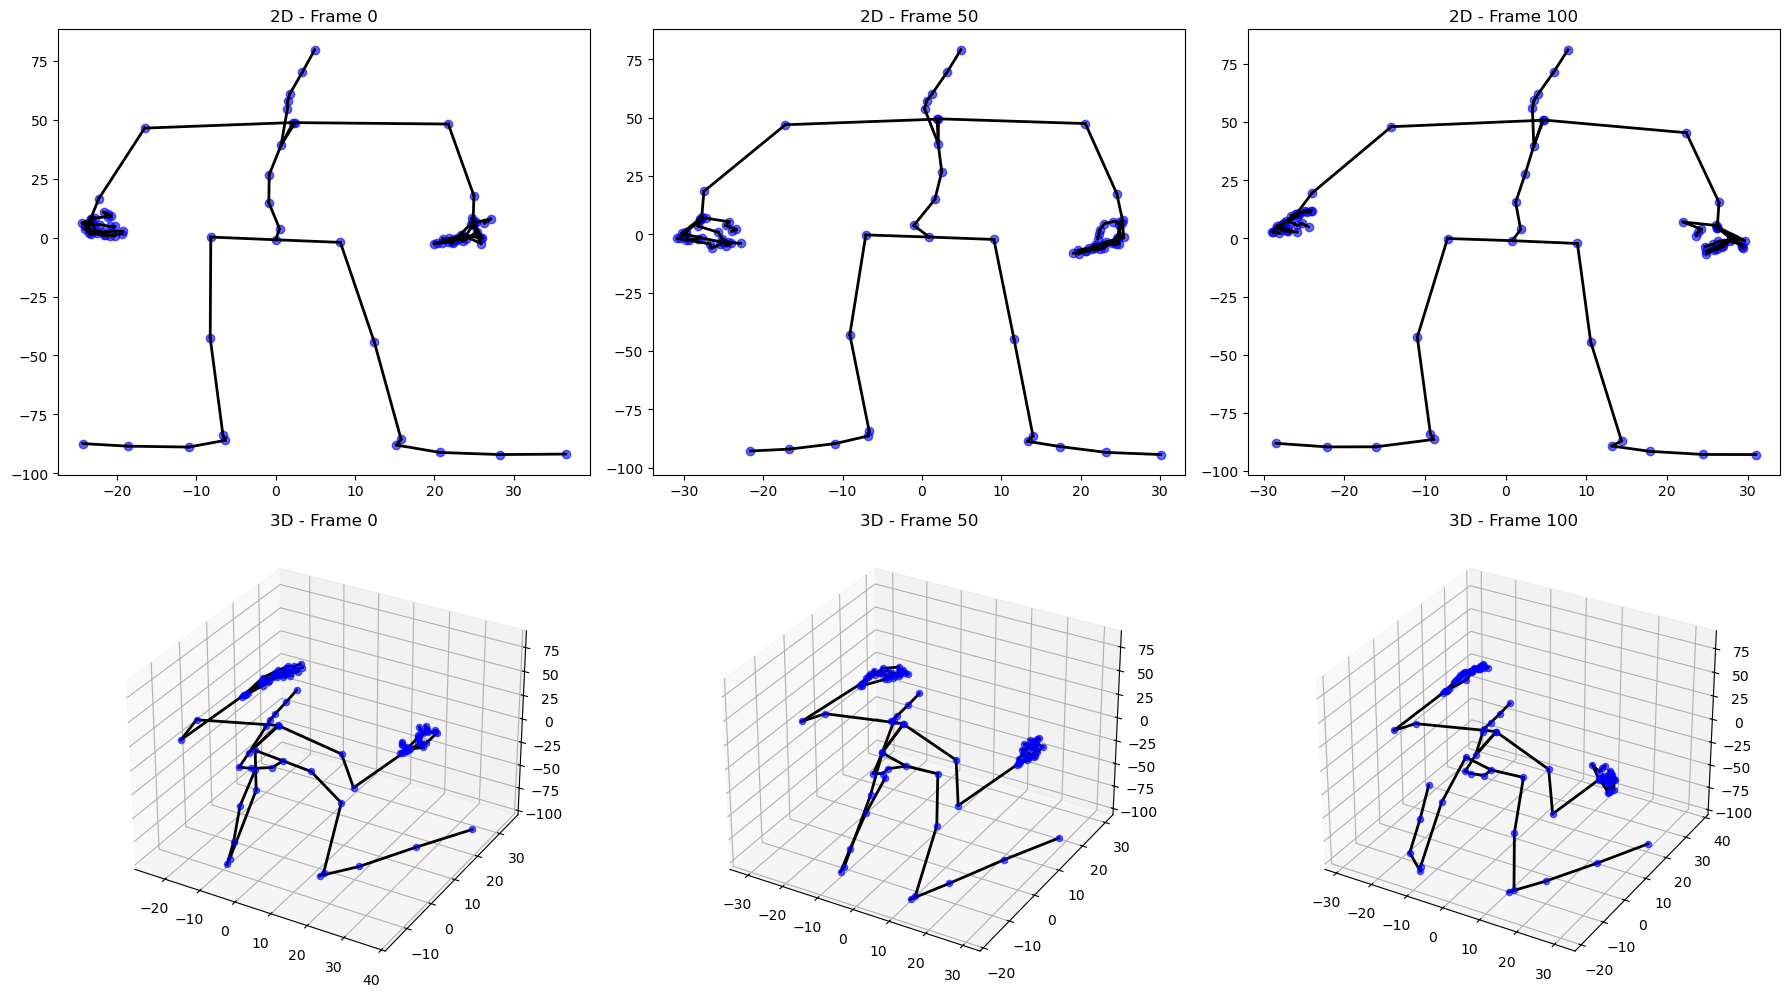


✅ Visualization complete!


In [8]:
print("="*60)
print("VISUALIZING MODEL OUTPUT FROM NPY")
print("="*60)

npy_file = "./checkpoints/beat/test_100/motion_102.npy"
m_model = np.load(npy_file)

print(f"\n📂 Loaded: {npy_file}")
print(f"   Shape: {m_model.shape}")
print(f"   Stats: min={m_model.min():.2f}, max={m_model.max():.2f}")

# Step 1: Denormalize
m_denorm = m_model * std + mean
print(f"\n✅ Denormalized")
print(f"   Stats: min={m_denorm.min():.2f}, max={m_denorm.max():.2f}")

# Step 2: Inverse transform
try:
    result = pipeline.inverse_transform([m_denorm])
    mocap_final = result[0]
    print(f"\n✅ Pipeline inverse_transform")
    print(f"   Output shape: {mocap_final.values.shape}")
    
    # Step 3: Constrain to reference skeleton
    parser_ = BVHParser()
    ref_mocap = parser_.parse("./datasets/2_scott_0_55_55.bvh")
    mocap_final = constrain_to_ref_skeleton(mocap_final, ref_mocap)
    
    # Step 4: Visualize
    print(f"\n🎨 Visualizing...")
    fig = plt.figure(figsize=(18, 10))
    
    frames = [0, 50, 100]
    for i, f in enumerate(frames):
        frame_idx = min(f, len(mocap_final.values)-1)
        
        # 2D
        ax2d = fig.add_subplot(2, 3, i+1)
        draw_stickfigure(mocap_final, frame=frame_idx, ax=ax2d)
        ax2d.set_title(f"2D - Frame {f}")
        
        # 3D
        ax3d = fig.add_subplot(2, 3, i+4, projection='3d')
        draw_stickfigure3d(mocap_final, frame=frame_idx, ax=ax3d)
        ax3d.set_title(f"3D - Frame {f}")
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Visualization complete!")
    
except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()

VISUALIZING MODEL OUTPUT FROM NPY

📂 Loaded: /home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT_numpy/npy/1/1_wayne_0_1_1_sentence_000.npy
   Shape: (164, 264)
   Stats: min=-2.91, max=5.32

✅ Denormalized
   Stats: min=-2.84, max=5.15
positions 2 eulers is not supported

✅ Pipeline inverse_transform
   Output shape: (164, 264)


/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['%s_Yposition'%joint] = pd.Series(data=track.values['%s_Yposition'%joint]+projected_root_pos[ryp], index=new_df.index)
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:596: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['%s_Zposition'%joint] = pd.Series(data=track.values['%s_Zposition'%joint]+projected_root_pos[rzp], index=new_df.index)
/home/serverai/ltdoanh/M

 -> Đang 'ép' khung xương theo Reference (Scott)...
 -> Hoàn tất Retargeting!

🎨 Visualizing...


/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/viz_tools.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(x=df['%s_Xposition'%joint][frame],
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/viz_tools.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=df['%s_Yposition'%joint][frame],
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/viz_tools.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

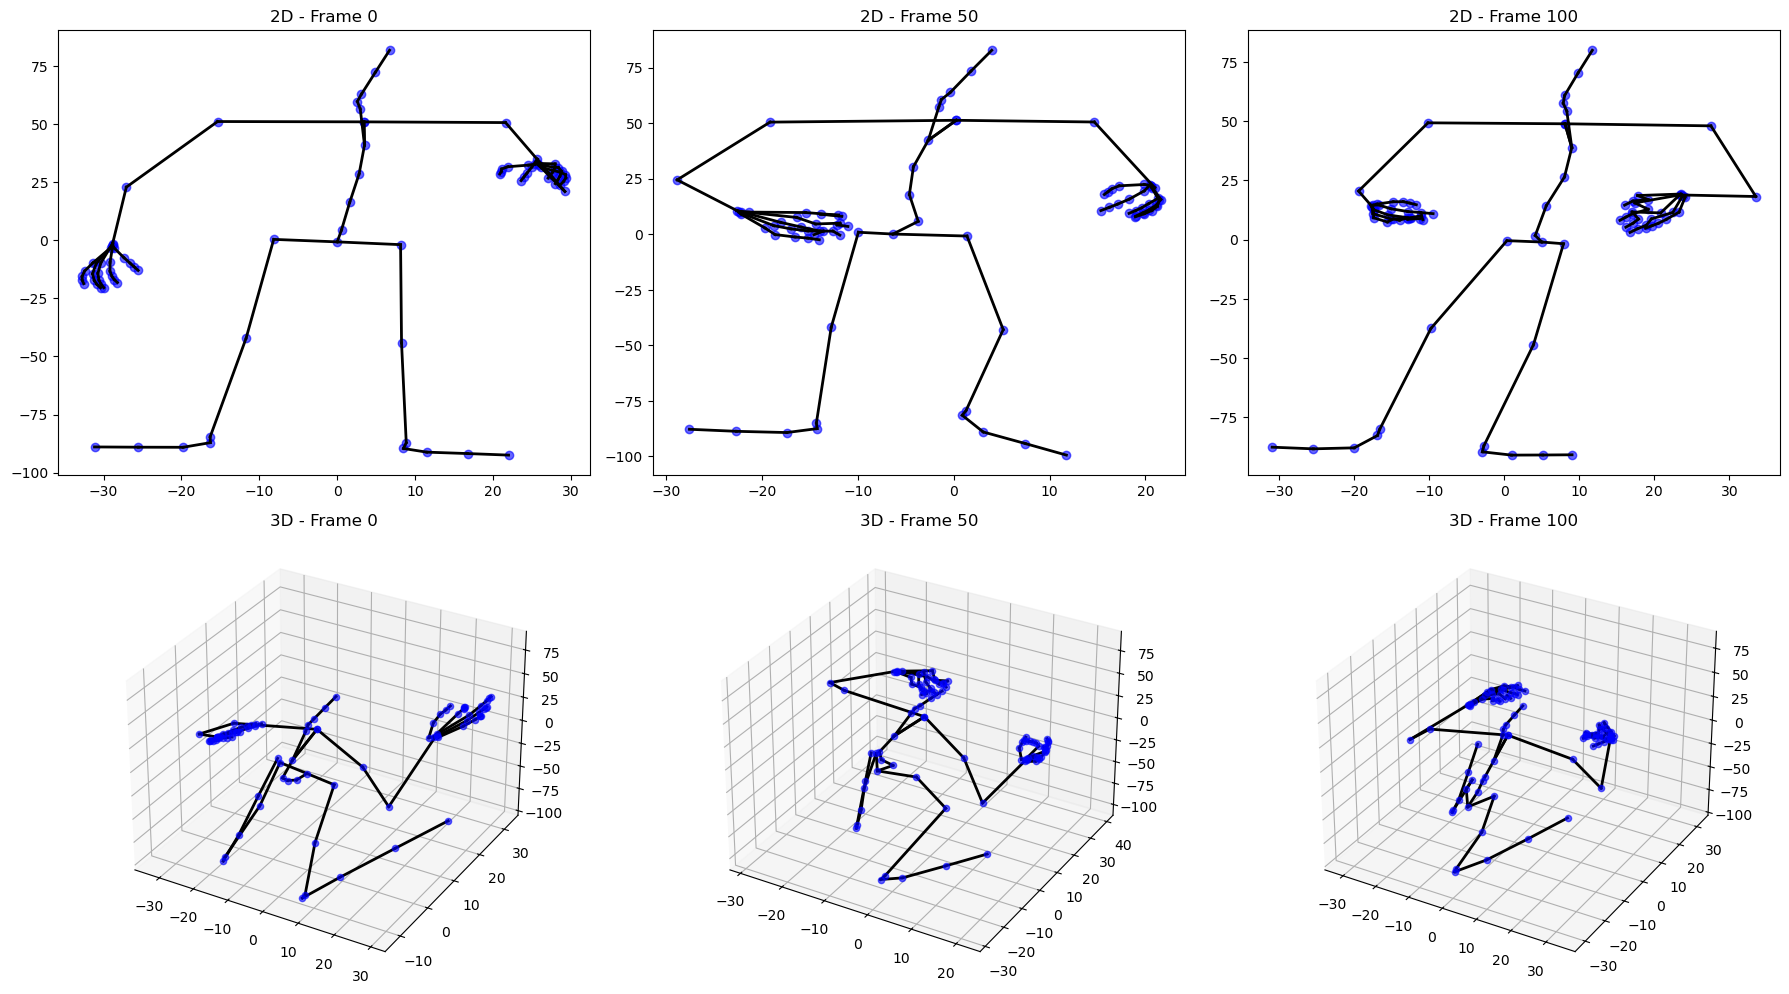


✅ Visualization complete!


In [6]:
print("="*60)
print("VISUALIZING MODEL OUTPUT FROM NPY")
print("="*60)

npy_file = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT_numpy/npy/1/1_wayne_0_1_1_sentence_000.npy"
m_model = np.load(npy_file)

print(f"\n📂 Loaded: {npy_file}")
print(f"   Shape: {m_model.shape}")
print(f"   Stats: min={m_model.min():.2f}, max={m_model.max():.2f}")

# Step 1: Denormalize
m_denorm = m_model * std + mean
print(f"\n✅ Denormalized")
print(f"   Stats: min={m_denorm.min():.2f}, max={m_denorm.max():.2f}")

# Step 2: Inverse transform
try:
    result = pipeline.inverse_transform([m_denorm])
    mocap_final = result[0]
    print(f"\n✅ Pipeline inverse_transform")
    print(f"   Output shape: {mocap_final.values.shape}")
    
    # Step 3: Constrain to reference skeleton
    parser_ = BVHParser()
    ref_mocap = parser_.parse("./datasets/2_scott_0_55_55.bvh")
    mocap_final = constrain_to_ref_skeleton(mocap_final, ref_mocap)
    
    # Step 4: Visualize
    print(f"\n🎨 Visualizing...")
    fig = plt.figure(figsize=(18, 10))
    
    frames = [0, 50, 100]
    for i, f in enumerate(frames):
        frame_idx = min(f, len(mocap_final.values)-1)
        
        # 2D
        ax2d = fig.add_subplot(2, 3, i+1)
        draw_stickfigure(mocap_final, frame=frame_idx, ax=ax2d)
        ax2d.set_title(f"2D - Frame {f}")
        
        # 3D
        ax3d = fig.add_subplot(2, 3, i+4, projection='3d')
        draw_stickfigure3d(mocap_final, frame=frame_idx, ax=ax3d)
        ax3d.set_title(f"3D - Frame {f}")
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Visualization complete!")
    
except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()